GPU 서버에 옮겨서 돌리면 될듯

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from SAM import SAM
from tqdm import tqdm


LR = 0.01
RHO=0.1
WEIGHT_DECAY = 0.0
MOMENTUM = 0.9
IS_LAZY = True

SEED = 0

if IS_LAZY:
    os.environ['PT_HPU_LAZY_MODE'] = '1'
else:
    os.environ['PT_HPU_LAZY_MODE'] = '0'


In [2]:
torch.manual_seed(SEED)          # CPU 시드 고정
torch.cuda.manual_seed(SEED)     # 현재 GPU의 시드 고정
torch.cuda.manual_seed_all(SEED) # 모든 GPU의 시드 고정
np.random.seed(SEED)
device = torch.device("cuda:7")

class MinimalModel(nn.Module):
    linear1: nn.Module
    linear2: nn.Module

    def __init__(self):
        super(MinimalModel, self).__init__()
        self.linear1: nn.Module = nn.Linear(in_features=2, out_features=1, bias=False)
        self.linear2: nn.Module = nn.Linear(in_features=1, out_features=1, bias=False)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        out1 = self.linear1(x)
        out1 = self.activation(out1)
        out2 = self.linear2(out1)
        out2 = out2.flatten()
        return out2
    

model = MinimalModel().to(device)
if not IS_LAZY:
    model = torch.compile(model)

loss_func = nn.MSELoss()

X = np.array([[1.05, 0.95], [0.95, 1.05]])
y = np.array([1.0, -1.0])
epoch_nums = 50000

X = torch.tensor(X).to(device, dtype=torch.float32)
y = torch.tensor(y).to(device, dtype=torch.float32)

optimizer = SAM(model.parameters(), optim.SGD, lr=LR, rho=RHO, 
                weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

loss_list = []
state_dict_list = []
pbar = tqdm(range(epoch_nums))

# Full batch SAM
for epoch in pbar:
    optimizer.zero_grad()
    out = model(X)
    loss = loss_func(out, y)
    loss_list.append(loss.item())
    pbar.set_postfix({'loss': loss.item()})
    detached_state_dict = {}
    for name, param in model.state_dict().items():
        detached_state_dict[name] = param.detach().cpu().numpy()
    state_dict_list.append(detached_state_dict)
    loss.backward()
    #htcore.mark_step()
    optimizer.first_step(zero_grad=True)
    #htcore.mark_step()
    out2 = model(X)
    second_loss = loss_func(out2, y)
    second_loss.backward()
    #htcore.mark_step()
    optimizer.second_step(zero_grad=True)
    #htcore.mark_step()

import pickle as pkl
to_save = [loss_list, state_dict_list]
if IS_LAZY:
    with open("verify_lazy_nvidia.pkl", 'wb') as f:
        pkl.dump(to_save, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open("verify_eager_nvidia.pkl", 'wb') as f:
        pkl.dump(to_save, f, protocol=pkl.HIGHEST_PROTOCOL)

100%|██████████| 50000/50000 [02:15<00:00, 368.62it/s, loss=1.11e-6] 


In [4]:
y

tensor([ 1., -1.], device='cuda:7', dtype=torch.float64)

In [2]:
import pickle as pkl

data_eager = pkl.load(open("verify_eager.pkl", 'rb'))
data_lazy = pkl.load(open("verify_lazy.pkl", 'rb'))
nvidia_eager = pkl.load(open("verify_eager_nvidia.pkl", 'rb'))
nvidia_lazy = pkl.load(open("verify_lazy_nvidia.pkl", 'rb'))

[]

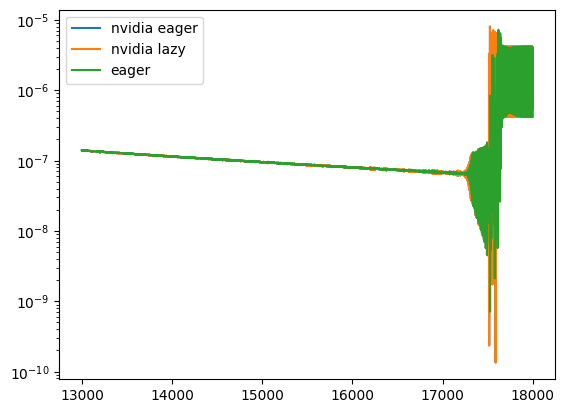

In [21]:
import matplotlib.pyplot as plt
import numpy as np
time_step = np.arange(13000, 18000)

plt.plot(time_step, np.array(nvidia_eager[0])[time_step], label='nvidia eager')
plt.plot(time_step, np.array(nvidia_lazy[0])[time_step], label='nvidia lazy')
plt.plot(time_step, np.array(data_eager[0])[time_step], label='eager')
#plt.plot(time_step, np.array(data_lazy[0])[time_step], label='lazy')
plt.legend()
plt.yscale('log')
plt.plot()

In [20]:
print(min(data_eager[0]))
print(min(data_lazy[0]))
print(min(nvidia_eager[0]))
print(min(nvidia_lazy[0]))


7.131077950361941e-10
6.920863881987316e-11
1.3509016127954965e-10
1.3509016127954965e-10


In [21]:
np.array(data_eager[0][17500:18000]) / np.array(data_lazy[0][17500:18000])

array([3.85493376e-01, 4.83340210e+00, 3.45869658e-01, 3.35918125e+00,
       5.99798969e-01, 9.37779659e-01, 2.61955645e+00, 3.22633277e-01,
       5.79039033e+01, 1.15897366e-01, 1.01129601e+00, 4.84232795e-02,
       8.11957356e-02, 5.91891353e-01, 3.69462902e-02, 2.55560854e-02,
       1.57984094e-02, 9.87660679e+01, 3.25781478e-03, 1.70455229e-02,
       2.54035617e-03, 2.83490942e-02, 1.13061313e+01, 2.32980568e-02,
       2.75327718e-01, 1.97476124e-02, 1.57364311e+01, 1.77988671e+00,
       1.78397494e-01, 3.26085448e-01, 3.60809434e-01, 8.31429790e-01,
       1.32991726e+02, 9.66142984e-01, 7.87858953e-03, 5.35809913e+01,
       2.18136705e+01, 5.09963854e-01, 1.29146388e+00, 1.87545734e-01,
       1.94696954e-02, 1.01366057e+01, 2.55392834e+01, 6.65240943e-02,
       9.50214123e-02, 3.02428221e+01, 1.08434307e+00, 7.13790593e+00,
       3.39168784e+01, 6.18041313e-02, 2.86136605e+01, 3.54388196e+00,
       1.12288886e+00, 4.14131700e-01, 5.21448624e-01, 9.26148125e-02,
      